# Image Segmentation

The main objectives of this module are:

* Use & compare different methods of segmentation:
    * Histogram-based
    * Texture-based
    * Region growing
* Detect objects and extract object features.
* Understand corner detection and basic object recognition

## 1. Histogram segmentation

In the previous labs, whenever it was necessary to make a decision on the "best threshold" for segmentation (like with the brown color distance), we made arbitrary decisions based on trial and error. This means that the method cannot be automated, which is always a downside.

In histogram segmentation, we make the hypothesis that the histogram is composed of distinct separable distributions, and we try to find the best threshold to separate those distributions.

The optimal threshold and the Otsu threshold are two different methods to try to find the best way to split an histogram in 2 distributions.

The optimal threshold tries to maximize the distance between the centroid of the two distributions by an iterative method, while the Otsu threshold tries all possible thresholds and finds the one that maximize the inter-class variance while minimizing the intra-class variance.

Let's code both of those and apply them to the cameraman.jpg image as :

1. Create a function to compute the optimal threshold for an 8 bit image. Apply on the cameraman image.
1. Compute the Otsu threshold for an 8-bit image, by optimizing within variance or inter-class variance for each possible theshold *t*. See [here](http://nbviewer.jupyter.org/github/odebeir/info-h-500-501/blob/ver_2016-2017/04-Image%20segmentation/01-Histogram%20based%20image%20segmentation.ipynb) how to compute the Otsu threshold.

In [5]:
from skimage.filters import threshold_otsu
import numpy as np

def optimal_threshold(h, t_init=128):
    """
    Trouve le seuil optimal en maximisant la distance entre les centroïdes
    h: histogramme (array de 256 valeurs)
    t_init: seuil initial
    """
    t = t_init
    for iteration in range(100):  # max 100 itérations
        # Calcul des centroïdes des 2 classes
        bins = np.arange(256)
        
        # Classe 1: pixels < t
        h1 = h[:t]
        w1 = np.sum(h1)
        if w1 > 0:
            mu1 = np.sum(bins[:t] * h1) / w1
        else:
            mu1 = 0
        
        # Classe 2: pixels >= t
        h2 = h[t:]
        w2 = np.sum(h2)
        if w2 > 0:
            mu2 = np.sum(bins[t:] * h2) / w2
        else:
            mu2 = 255
        
        # Nouveau seuil = moyenne des centroïdes
        t_new = int((mu1 + mu2) / 2)
        
        if t_new == t:
            break
        t = t_new
    
    return t

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

imgCamera = imread('data/camera.jpg')
hist, bins = np.histogram(imgCamera.ravel(), bins=256, range=(0, 256))

print("optimal_threshold:", optimal_threshold(hist, t_init=128))

optimal_threshold: 87


Now the Otsu threshold:

In [7]:
def otsu_threshold(h):
    """
    Trouve le seuil d'Otsu en maximisant la variance inter-classe
    h: histogramme normalisé (probabilités)
    """
    total = np.sum(h)
    h_norm = h / total  # normalisation
    
    bins = np.arange(256)
    mu_T = np.sum(bins * h_norm)  # moyenne globale
    
    best_t = 0
    max_sigma_b = 0
    
    for t in range(1, 256):
        # Poids des classes
        w0 = np.sum(h_norm[:t])
        w1 = np.sum(h_norm[t:])
        
        if w0 == 0 or w1 == 0:
            continue
        
        # Moyennes des classes
        mu0 = np.sum(bins[:t] * h_norm[:t]) / w0
        mu1 = np.sum(bins[t:] * h_norm[t:]) / w1
        
        # Variance inter-classe
        sigma_b = w0 * w1 * (mu0 - mu1) ** 2
        
        if sigma_b > max_sigma_b:
            max_sigma_b = sigma_b
            best_t = t
    
    return best_t

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

imgCamera = imread('data/camera.jpg')
hist, bins = np.histogram(imgCamera.ravel(), bins=256, range=(0, 256))

print("otsu's threshold:", otsu_threshold(hist))

otsu's threshold: 88


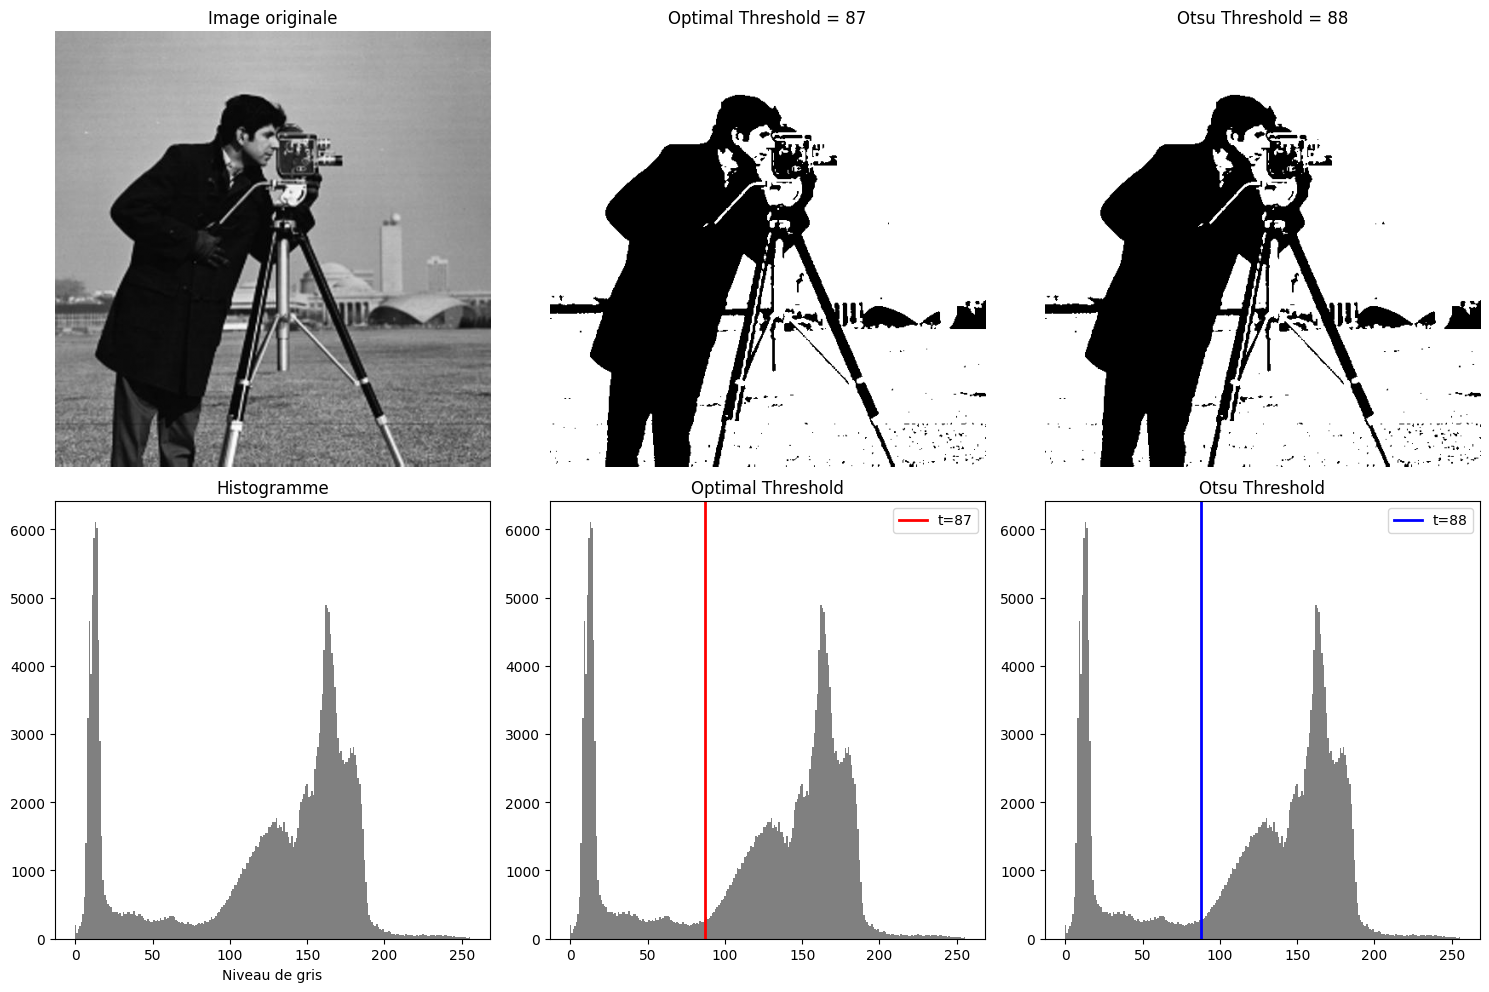

Seuil optimal: 87
Seuil d'Otsu: 88


In [9]:
# Calculate thresholds
t_optimal = optimal_threshold(hist, t_init=128)
t_otsu = otsu_threshold(hist)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(imgCamera, cmap='gray')
axes[0, 0].set_title('Image originale')
axes[0, 0].axis('off')

axes[0, 1].imshow(imgCamera > t_optimal, cmap='gray')
axes[0, 1].set_title(f'Optimal Threshold = {t_optimal}')
axes[0, 1].axis('off')

axes[0, 2].imshow(imgCamera > t_otsu, cmap='gray')
axes[0, 2].set_title(f'Otsu Threshold = {t_otsu}')
axes[0, 2].axis('off')

# Histogrammes avec seuils
axes[1, 0].bar(bins[:-1], hist, width=1, color='gray')
axes[1, 0].set_title('Histogramme')
axes[1, 0].set_xlabel('Niveau de gris')

axes[1, 1].bar(bins[:-1], hist, width=1, color='gray')
axes[1, 1].axvline(t_optimal, color='red', linewidth=2, label=f't={t_optimal}')
axes[1, 1].set_title('Optimal Threshold')
axes[1, 1].legend()

axes[1, 2].bar(bins[:-1], hist, width=1, color='gray')
axes[1, 2].axvline(t_otsu, color='blue', linewidth=2, label=f't={t_otsu}')
axes[1, 2].set_title('Otsu Threshold')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

print(f"Seuil optimal: {t_optimal}")
print(f"Seuil d'Otsu: {t_otsu}")

Unsuprisingly, we get a very similar result to the optimal threshold. The advantage here is that we are certain that it's the best threshold (according to our criteria) as we test all possibilities, while the optimal threshold might converge into "local minima" (it's not the case with the cameraman, but it could happen with more complex histograms).

In [10]:
from skimage.morphology import disk, opening, closing

## -- Your code here -- ##


### Post-processing


Segmentation from histogram methods are almost always "noisy", in the sense that there are many small "segmented objects" in the background, and holes in the actual segmented object. Morphological operations are often used to clean up this segmentation, with opening operations to remove small objects, and closing operations to remove holes.

In [11]:
from skimage.morphology import disk, opening, closing

## -- Your code here -- ##

**Need more help? You can check the following videos:**

* [Manual thresholding](https://www.youtube.com/watch?v=rgKkws_fqz4&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=24)
* [Optimal threshold](https://www.youtube.com/watch?v=7B1cs0PARtg&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=25)
* [Otsu threshold](https://www.youtube.com/watch?v=mz26bssSLds&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=26)

## 2. Texture segmentation

The problem with histogram segmentation is that it doesn't take into account the spatial distribution of the pixels. As we saw in the first lab, the histogram remains exactly the same if we shuffle the image.

Therefore, in image analysis, we will often use the concept of neighbourdhoods to characterize a pixel. If we want to perform a neigbourhood-based operation on an image, a common tactic is the "sliding window". With sliding window, we start from a corner of the image and take a neigbourhood of a certain size, on which we perform the required computations. Then, we "slide" this neighbourhood so that it covers a new (possibly overlapping) region. We keep doing that until we've gone through the entire image.

This is exactly what we did when we coded the 2D convolution. Here, instead of doing the convolution operation, we want to compute texture descriptors - in this case the dissimilarity property of the co-occurence matrix.

Texture segmentation uses regional descriptors to segment the image based on the local texture. A simple algorithm is provided below, which:

* Extract neighborhoods with the sliding window method
* Compute the local maximum on the neighborhood and put it in a "descriptor" image
* Use Otsu thresholding on the descriptor image to segment it
* Display the results

Let's take a look at the zebra image.

In [12]:
from skimage.feature import graycomatrix, graycoprops
from skimage.io import imread
from skimage import img_as_ubyte

# Open zebra image as an 8-bit integer grayscale image
im = img_as_ubyte(imread("zebra.jpg", as_gray=True))

plt.figure()
plt.imshow(im, cmap=plt.cm.gray)
plt.show()

FileNotFoundError: No such file: 'c:\Users\tajan\Documents\COURS\ImageProcessing\ImageProcessing\3_Image_Segmentation\zebra.jpg'

Whenever we want to do a sliding window, we need to decide:

The size of the patch
The "stride" by which we will move the sliding window over at each step of the algorithm
If those two values are the same, there will be no overlap between the regions. If they aren't, we will have to decide what to do about the overlap. In the kernel convolution, we used a stride of 1, and the rule was simply that we replaced the pixel at the center of the kernel by the result of the operation.

Let's start here by taking a patch size of 100x100 pixels. Our rule will be to fill the entire 100x100 pixel region with the result of the operation, which is the dissimilarity value.

Since we use the cooccurrence matrix, we need to decide of the displacement and angle. What we hope to highlight is the texture of the zebra. Let's try with an angle of 0 and a displacement of 25 pixels.

In [ ]:
def texture_descriptor(N):
     ## -- Your code here -- ##

That seems like a nice start. If we change the angle, we can see that we highlight different regions of the zebra texture:

In [ ]:
def texture_descriptor(N):
     ## -- Your code here -- ##

SyntaxError: incomplete input (4260220555.py, line 2)

An interesting idea might be to use different angles and take the maximum value. The maximum value is useful here because we expect the zebra to have a high dissimalirity for at least one angle for this displacement in any region within it, while the background should have low dissimilarities for any angle.

In [ ]:
def texture_descriptor(N):
     ## -- Your code here -- ##

If we want to be a bit more precise, we can use a smaller window.

In [ ]:
 ## -- Your code here -- ##

A sligthly more complex (but better) option is also to add some overlap : we can use a stride that is smaller than the size of the window, and only set the result in the central region of the neighborhood:

In [ ]:
def sliding_window_overlap(im, PATCH_SIZE, STRIDE):
      ## -- Your code here -- ## 

We can see that the result is much better, but the more precise we want to be in the result, the more time it will take to compute. Also, our current method cannot give a prediction for the border region of the image. This could be addressed with padding (or we can just keep ignoring it).

The last step we need is to do a thresholding on the output image:

In [ ]:
 ## -- Your code here -- ##

because of the 0s on the borders, the histogram has a single spike on 0. So, to obtain a better histogram ignore the borders.

In [ ]:
 ## -- Your code here -- ## 

That's better. Let's use Otsu to find the best threshold:

In [ ]:
 ## -- Your code here -- ## 

Finally, let's use this mask on the image to see what our result looks like.

In [ ]:
## -- Your code here -- ## 

That's quite good. We could play with the treshold to have slightly better results (but with a less automated process), and we could use some morphological post-processing to clean it up and smoothen the borders:

In [ ]:
## -- Your code here -- ## 

Using the above example as a starting point, replace the "maximum" texture descriptor by properties from the co-occurrence matrix:
* Compute the co-occurrence matrix on the neighborhood (see [greycomatrix](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.greycomatrix)). Test different angles & displacements.
* Test different properties (see [greycoprops](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.greycoprops))

Try to segment the zebra image as best as you can using those descriptors.

**Need more help? You can check the following videos:**

* [Region descriptors](https://www.youtube.com/watch?v=5F9aPiab8PA&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=27)
* [Properties of the co-occurrence matrix](https://www.youtube.com/watch?v=NR3vrkZ9tyg&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=28)
* [Texture segmentation](https://www.youtube.com/watch?v=b-SGhLu-R0c&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=29)

## 3. Region growing

In region growing algorithms, we start from "markers" which act as seed points, and grow the segmented regions from those markers. A well-known region-growing algorithm uses the watershed transform. 

For the watershed algorithm, we need to :
1. Compute a gradient image
2. Select markers
3. Apply watershed with those markers.

The example below shows the segmentation of coins using the watershed transform:

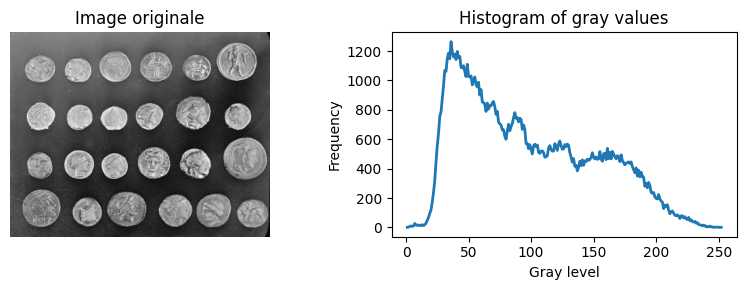

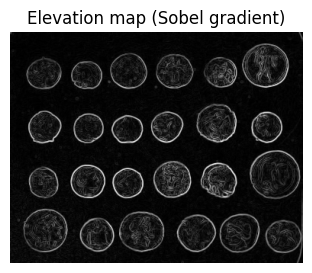

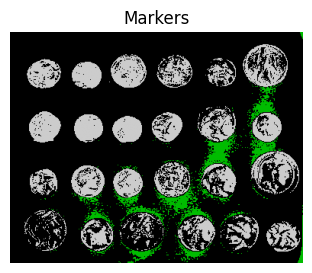

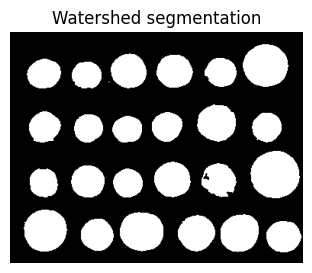

Nombre de pièces détectées: 25


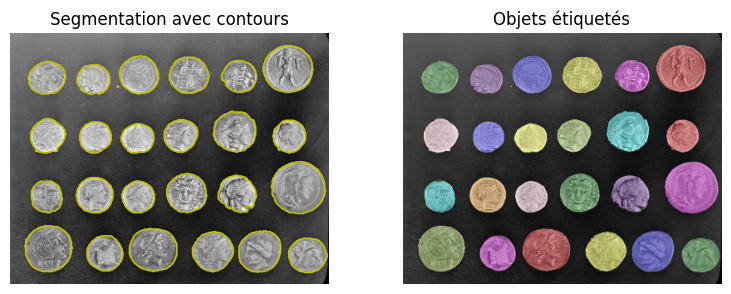

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.exposure import histogram
from skimage.filters import sobel
from skimage import segmentation
from skimage.color import label2rgb
import scipy.ndimage as ndi  # Import manquant pour binary_fill_holes et label

# Charger l'image de pièces de monnaie
coins = data.coins()
hist, hist_centers = histogram(coins)

# Afficher l'image et son histogramme
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(coins, cmap=plt.cm.gray)
axes[0].set_title('Image originale')
axes[0].axis('off')
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('Histogram of gray values')
axes[1].set_xlabel('Gray level')
axes[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

# Étape 1: Créer une carte d'élévation avec le gradient de Sobel
# (les bordures des objets auront des valeurs élevées)
elevation_map = sobel(coins)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(elevation_map, cmap=plt.cm.gray)
ax.set_title('Elevation map (Sobel gradient)')
ax.axis('off')
plt.show()

# Étape 2: Définir les marqueurs (seeds) pour l'algorithme watershed
# Marqueur 1: pixels très sombres (fond)
# Marqueur 2: pixels très clairs (centres des pièces)
markers = np.zeros_like(coins)
markers[coins < 30] = 1   # Background marker
markers[coins > 150] = 2  # Foreground marker (coins)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(markers, cmap=plt.cm.nipy_spectral)
ax.set_title('Markers')
ax.axis('off')
plt.show()

# Étape 3: Appliquer la transformation de watershed
segmentation_coins = segmentation.watershed(elevation_map, markers)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(segmentation_coins, cmap=plt.cm.gray)
ax.set_title('Watershed segmentation')
ax.axis('off')
plt.show()

# Étape 4: Post-traitement et étiquetage des objets individuels
# Convertir en masque binaire et remplir les trous
segmentation_coins = ndi.binary_fill_holes(segmentation_coins - 1)
# Étiqueter chaque objet connecté
labeled_coins, num_coins = ndi.label(segmentation_coins)
print(f"Nombre de pièces détectées: {num_coins}")

# Créer une superposition colorée
image_label_overlay = label2rgb(labeled_coins, image=coins, bg_label=0)

# Affichage final: contours + overlay coloré
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
axes[0].imshow(coins, cmap=plt.cm.gray)
axes[0].contour(segmentation_coins, [0.5], linewidths=1.2, colors='y')
axes[0].set_title('Segmentation avec contours')
axes[0].axis('off')
axes[1].imshow(image_label_overlay)
axes[1].set_title('Objets étiquetés')
axes[1].axis('off')

plt.tight_layout()
plt.show()

Adapt this method to work on the camera.jpg image.

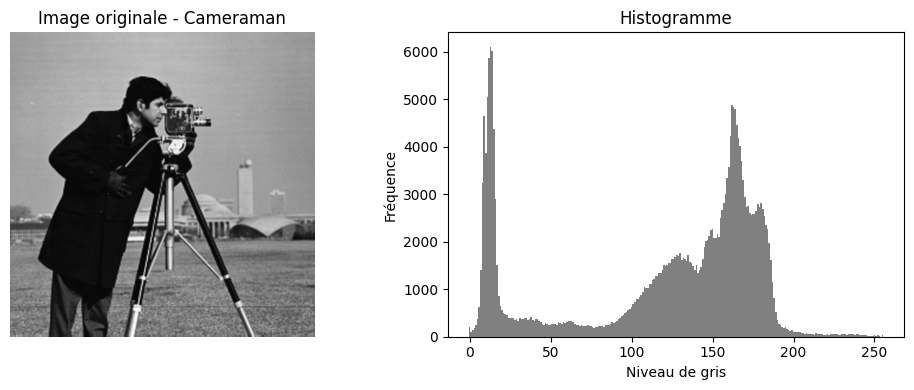

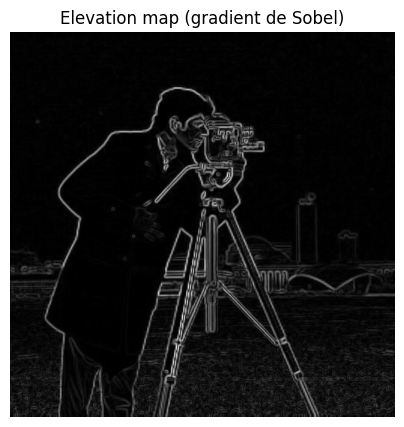

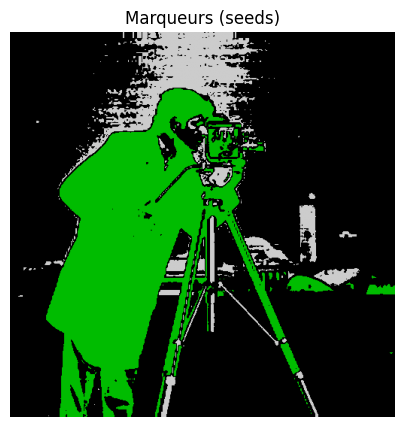

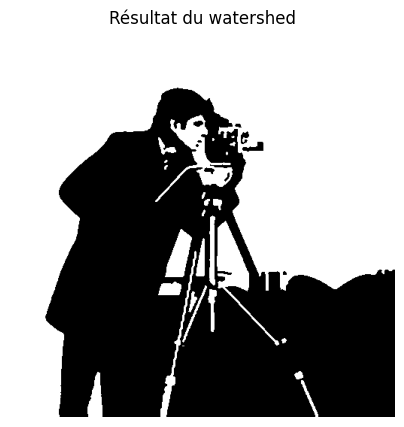

Nombre d'objets détectés: 3


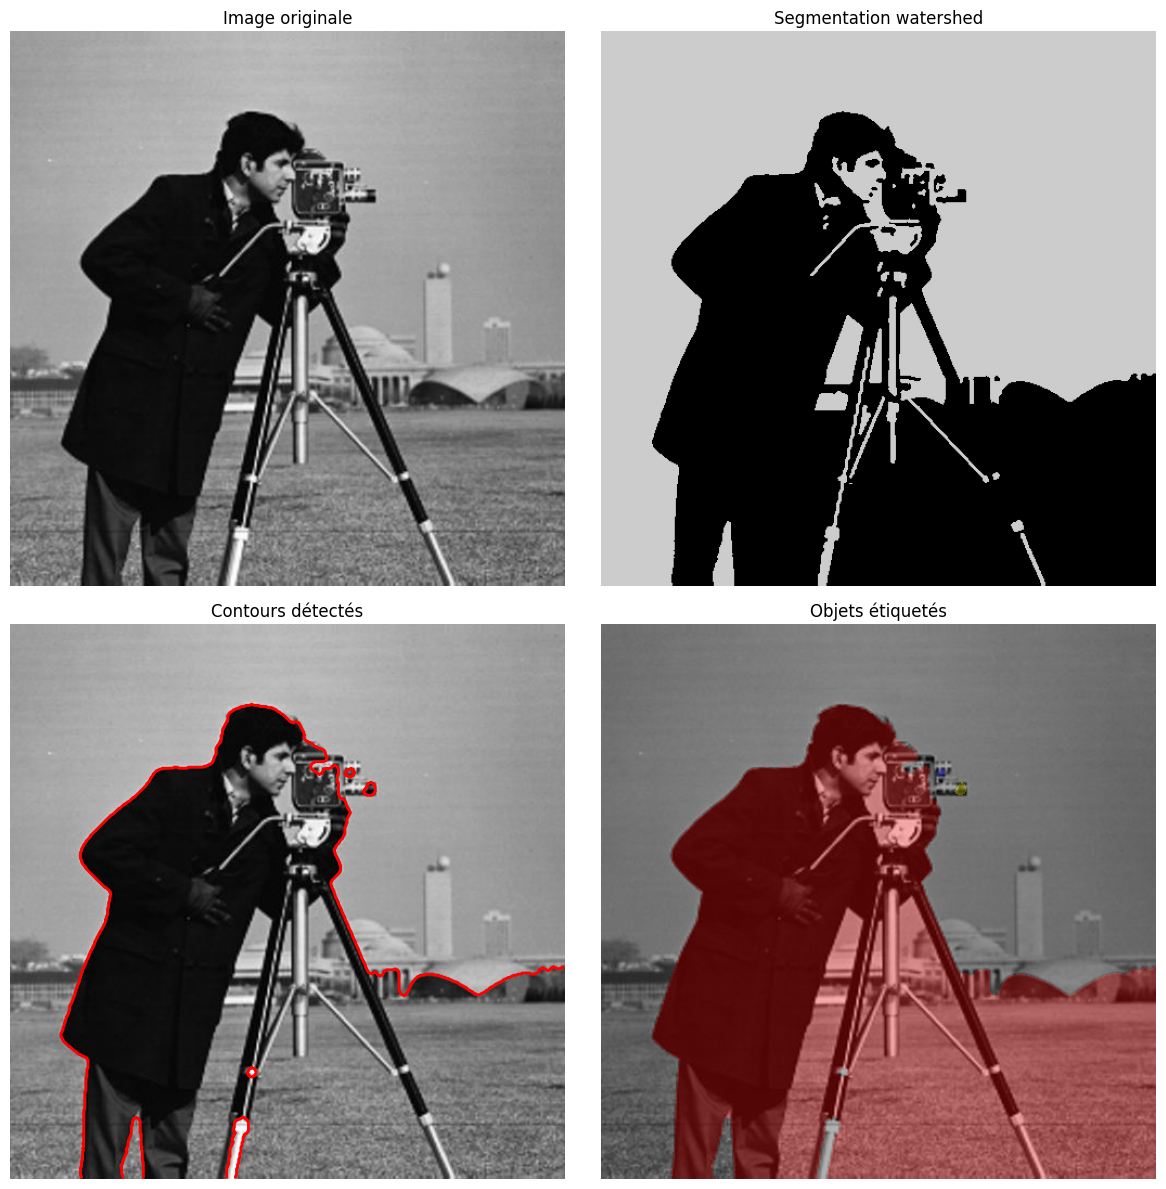

In [ ]:
from skimage.morphology import disk
import skimage.filters.rank as skr
from skimage.segmentation import mark_boundaries, watershed
from skimage.io import imread
from skimage.filters import sobel
from skimage.color import label2rgb
import scipy.ndimage as ndi

# Charger l'image camera.jpg
imgCamera = imread('data/camera.jpg')

# Convertir en grayscale si nécessaire
if imgCamera.ndim == 3:
    imgCamera = np.mean(imgCamera, axis=2).astype(np.uint8)
else:
    imgCamera = imgCamera.astype(np.uint8)

# Afficher l'image et son histogramme
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(imgCamera, cmap='gray')
axes[0].set_title('Image originale - Cameraman')
axes[0].axis('off')

hist, bins = np.histogram(imgCamera.ravel(), bins=256, range=(0, 256))
axes[1].bar(bins[:-1], hist, width=1, color='gray')
axes[1].set_title('Histogramme')
axes[1].set_xlabel('Niveau de gris')
axes[1].set_ylabel('Fréquence')
plt.tight_layout()
plt.show()

# Étape 1: Carte d'élévation avec le gradient de Sobel
elevation_map = sobel(imgCamera)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(elevation_map, cmap='gray')
ax.set_title('Elevation map (gradient de Sobel)')
ax.axis('off')
plt.show()

# Étape 2: Définir les marqueurs automatiquement
# En analysant l'histogramme, on peut identifier:
# - Pixels sombres (< 50): fond/ciel sombre
# - Pixels clairs (> 180): ciel clair
# - Pixels moyens: le cameraman

markers = np.zeros_like(imgCamera)
markers[imgCamera < 50] = 1    # Background sombre
markers[imgCamera > 180] = 2   # Ciel clair

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(markers, cmap='nipy_spectral')
ax.set_title('Marqueurs (seeds)')
ax.axis('off')
plt.show()

# Étape 3: Appliquer watershed
segmentation_camera = watershed(elevation_map, markers)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(segmentation_camera, cmap='gray')
ax.set_title('Résultat du watershed')
ax.axis('off')
plt.show()

# Étape 4: Post-traitement
# Extraire la région du cameraman (label 1 après watershed)
cameraman_mask = (segmentation_camera == 1)

# Remplir les trous
cameraman_mask_filled = ndi.binary_fill_holes(cameraman_mask)

# Appliquer des opérations morphologiques pour nettoyer
from skimage.morphology import opening, closing
cameraman_mask_clean = closing(opening(cameraman_mask_filled, disk(3)), disk(3))

# Étiqueter les objets
labeled_objects, num_objects = ndi.label(cameraman_mask_clean)
print(f"Nombre d'objets détectés: {num_objects}")

# Créer overlay coloré
image_label_overlay = label2rgb(labeled_objects, image=imgCamera, bg_label=0)

# Affichage final
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

axes[0, 0].imshow(imgCamera, cmap='gray')
axes[0, 0].set_title('Image originale')
axes[0, 0].axis('off')

axes[0, 1].imshow(segmentation_camera, cmap='nipy_spectral')
axes[0, 1].set_title('Segmentation watershed')
axes[0, 1].axis('off')

axes[1, 0].imshow(imgCamera, cmap='gray')
axes[1, 0].contour(cameraman_mask_clean, [0.5], linewidths=2, colors='red')
axes[1, 0].set_title('Contours détectés')
axes[1, 0].axis('off')

axes[1, 1].imshow(image_label_overlay)
axes[1, 1].set_title('Objets étiquetés')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

Another use of the watershed transform is to separate overlapping object. Try implementing it on the spear.png image.

* Compute the [distance transform](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.distance_transform_edt.html#scipy.ndimage.distance_transform_edt) of the image.
* Use the result to automatically find good markers.
* Use the watershed transform to separate the three objects.

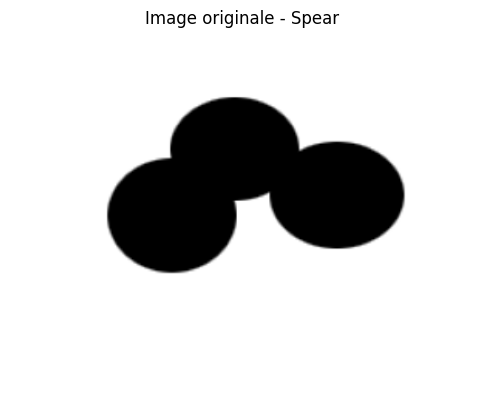

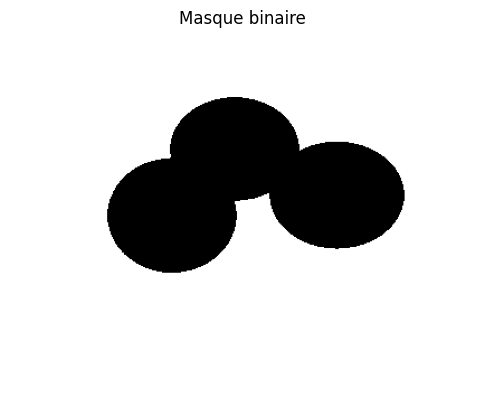

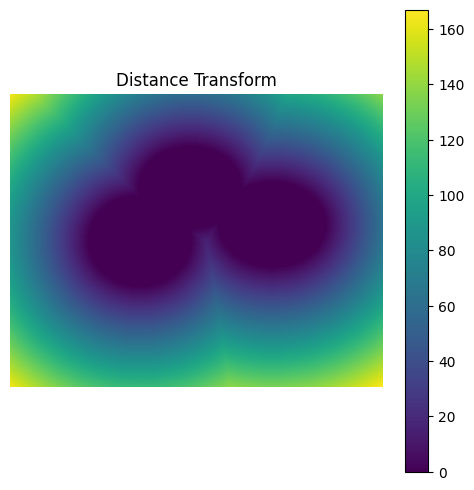

Nombre de marqueurs trouvés: 6


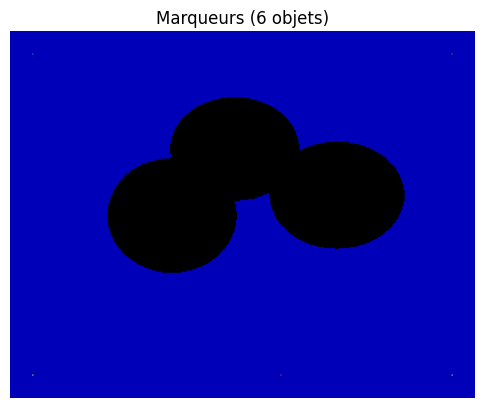

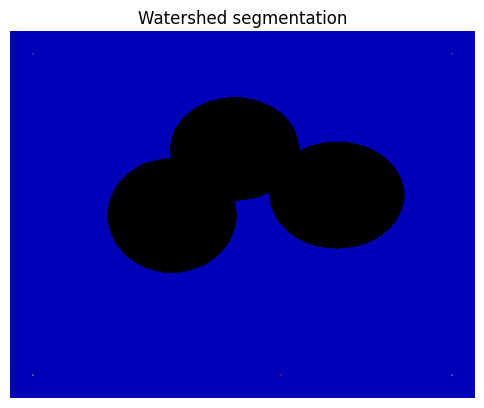

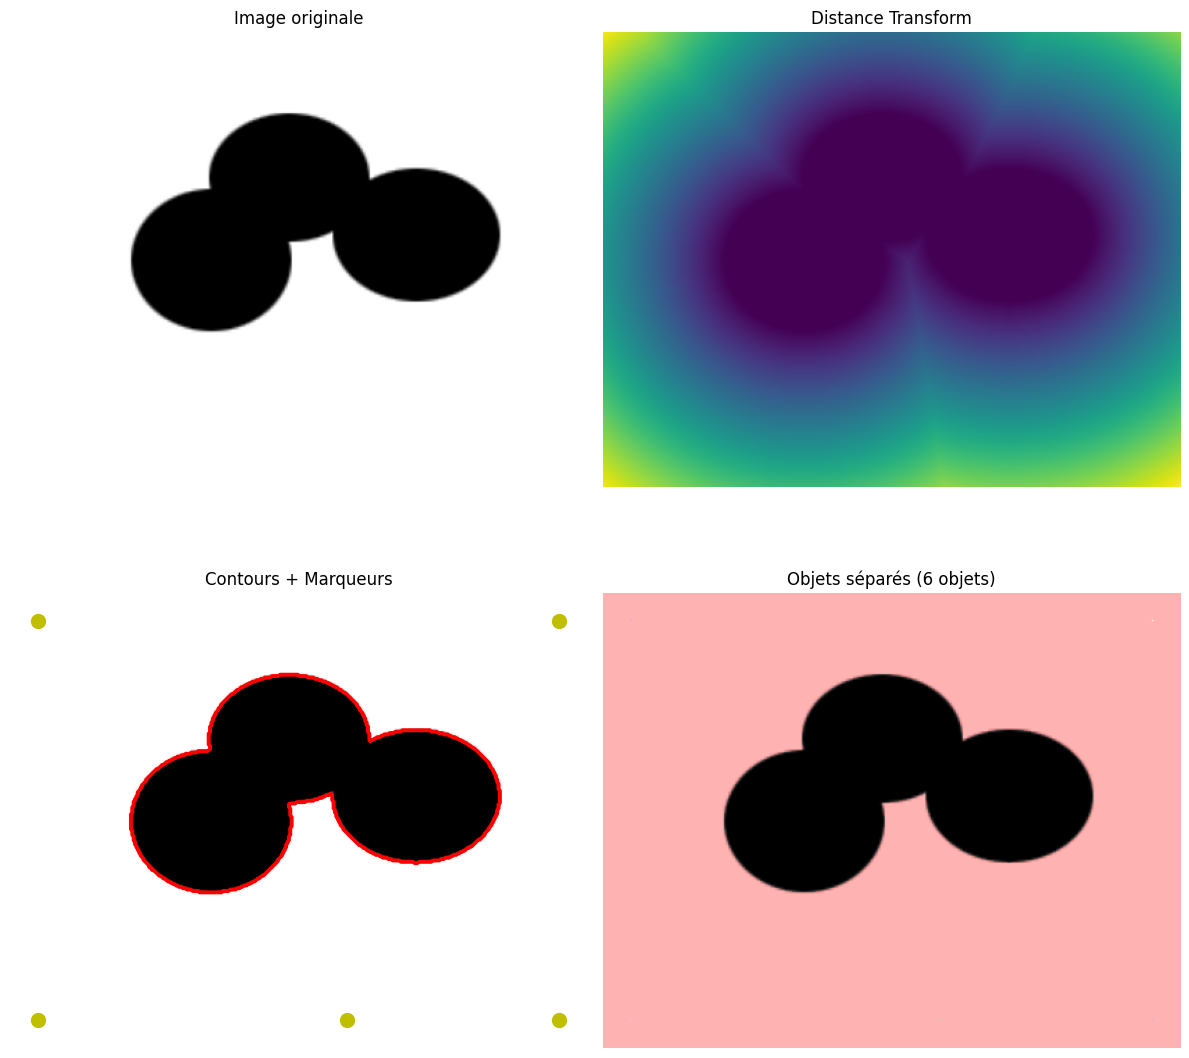

Nombre d'objets détectés: 6


In [ ]:
from scipy.ndimage import distance_transform_edt
from skimage.color import rgb2gray
from skimage.morphology import disk
import skimage.filters.rank as skr
from skimage.segmentation import mark_boundaries, watershed
from skimage.io import imread
from skimage.feature import peak_local_max
from skimage.measure import label
from skimage.filters import gaussian
import scipy.ndimage as ndi

# Charger l'image spear.png
imgSpear = imread('data/separ.png')

# Convertir en grayscale si nécessaire
if imgSpear.ndim == 3:
    imgSpear_gray = rgb2gray(imgSpear)
else:
    imgSpear_gray = imgSpear

# Afficher l'image originale
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(imgSpear)
ax.set_title('Image originale - Spear')
ax.axis('off')
plt.show()

# Étape 1: Créer un masque binaire (seuillage simple)
# On suppose que l'objet est clair sur fond sombre
threshold = 0.5
binary_mask = imgSpear_gray > threshold

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(binary_mask, cmap='gray')
ax.set_title('Masque binaire')
ax.axis('off')
plt.show()

# Étape 2: Calculer la distance transform
# La distance transform donne la distance de chaque pixel au bord le plus proche
distance = distance_transform_edt(binary_mask)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(distance, cmap='viridis')
ax.set_title('Distance Transform')
ax.axis('off')
plt.colorbar(ax.images[0], ax=ax)
plt.show()

# Étape 3: Trouver les marqueurs automatiquement
# Utiliser peak_local_max pour trouver les maxima locaux dans la distance transform
# Ces maxima correspondent aux centres des objets
local_maxima = peak_local_max(distance, min_distance=20, labels=binary_mask)

# Créer un masque des marqueurs
markers_mask = np.zeros_like(binary_mask, dtype=bool)
markers_mask[tuple(local_maxima.T)] = True

# Étiqueter les marqueurs
markers = label(markers_mask)

# Ajouter un marqueur pour le fond (label 0)
markers = markers + 1
markers[~binary_mask] = 0

print(f"Nombre de marqueurs trouvés: {markers.max()}")

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(markers, cmap='nipy_spectral')
ax.set_title(f'Marqueurs ({markers.max()} objets)')
ax.axis('off')
plt.show()

# Étape 4: Appliquer le watershed
# On utilise l'inverse de la distance transform comme élévation
# (les vallées seront les bordures entre objets)
labels_ws = watershed(-distance, markers, mask=binary_mask)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(labels_ws, cmap='nipy_spectral')
ax.set_title('Watershed segmentation')
ax.axis('off')
plt.show()

# Étape 5: Visualisation finale avec contours
from skimage.color import label2rgb

# Créer overlay coloré
image_label_overlay = label2rgb(labels_ws, image=imgSpear, bg_label=0)

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

axes[0, 0].imshow(imgSpear)
axes[0, 0].set_title('Image originale')
axes[0, 0].axis('off')

axes[0, 1].imshow(distance, cmap='viridis')
axes[0, 1].set_title('Distance Transform')
axes[0, 1].axis('off')

axes[1, 0].imshow(imgSpear)
axes[1, 0].contour(labels_ws, linewidths=2, colors='red')
axes[1, 0].plot(local_maxima[:, 1], local_maxima[:, 0], 'yo', markersize=10)
axes[1, 0].set_title('Contours + Marqueurs')
axes[1, 0].axis('off')

axes[1, 1].imshow(image_label_overlay)
axes[1, 1].set_title(f'Objets séparés ({labels_ws.max()} objets)')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print(f"Nombre d'objets détectés: {labels_ws.max()}")

**Need more help? You can check the following videos:**

* [Markers for region growing](https://www.youtube.com/watch?v=3e0-rE9zhFk&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=30)
* [Watershed transform](https://www.youtube.com/watch?v=GuVp7dlzEKE&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=31)
* [Distance transform](https://www.youtube.com/watch?v=s1eABOdNnVg&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=32)

## 4. Object features

The next step after segmentation is often to extract object features in order to recognize, classify, or measure information about the objects.

Using the image shapes.png try the following:

1. **Extract connected components** (see [label()](http://scikit-image.org/docs/dev/api/skimage.measure.html?highlight=label#skimage.measure.label)) of the shapes image and **display the centroid of the objects** (see [regionprops()](http://scikit-image.org/docs/dev/api/skimage.measure.html?highlight=regionprops#skimage.measure.regionprops))
1. For each image label, **extract the coordinates of the contour** (see [find_contours()](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.find_contours)) and **find the corners** of each objects.
1. Suggest a method to **classify the objects** in different categories.

Image détectée comme RGBA (4 canaux). Suppression du canal Alpha.
Nombre d'objets détectés: 17


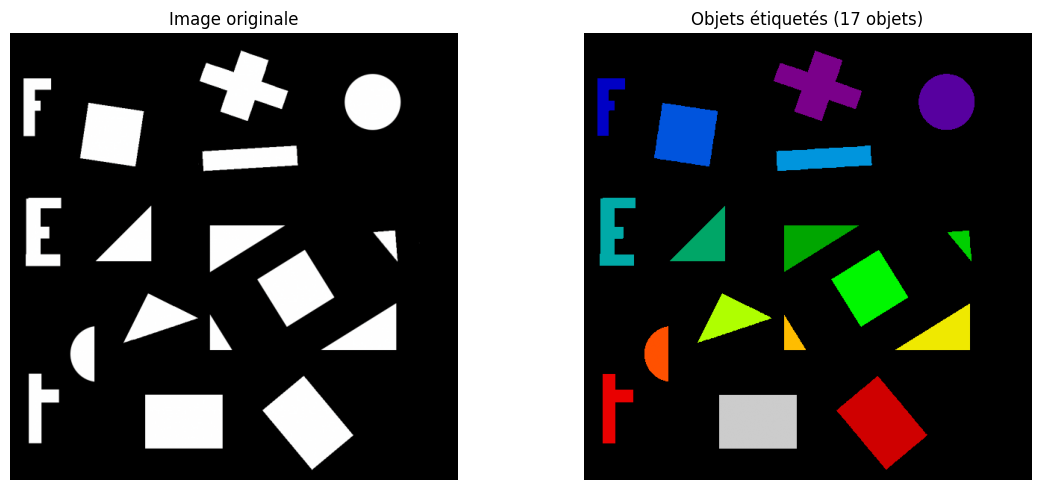


Objet 1:
  Centroïde: (313.0, 71.6)
  Aire: 5380.0
  Périmètre: 428.4
  Excentricité: 0.638
  Solidité: 0.703

Objet 2:
  Centroïde: (485.2, 93.2)
  Aire: 4422.0
  Périmètre: 246.2
  Excentricité: 0.052
  Solidité: 0.986

Objet 3:
  Centroïde: (29.6, 93.4)
  Aire: 1591.0
  Périmètre: 237.1
  Excentricité: 0.940
  Solidité: 0.738

Objet 4:
  Centroïde: (136.1, 137.1)
  Aire: 5628.0
  Périmètre: 310.2
  Excentricité: 0.057
  Solidité: 0.972

Objet 5:
  Centroïde: (320.8, 168.7)
  Aire: 3340.0
  Périmètre: 310.1
  Excentricité: 0.978
  Solidité: 0.950

Objet 6:
  Centroïde: (38.7, 267.3)
  Aire: 2715.0
  Périmètre: 345.9
  Excentricité: 0.911
  Solidité: 0.639

Objet 7:
  Centroïde: (163.7, 281.7)
  Aire: 2775.0
  Périmètre: 249.2
  Excentricité: 0.816
  Solidité: 1.000

Objet 8:
  Centroïde: (301.1, 279.4)
  Aire: 3150.0
  Périmètre: 282.1
  Excentricité: 0.879
  Solidité: 0.985

Objet 9:
  Centroïde: (506.6, 280.1)
  Aire: 623.0
  Périmètre: 119.9
  Excentricité: 0.860
  Solidité: 0.92

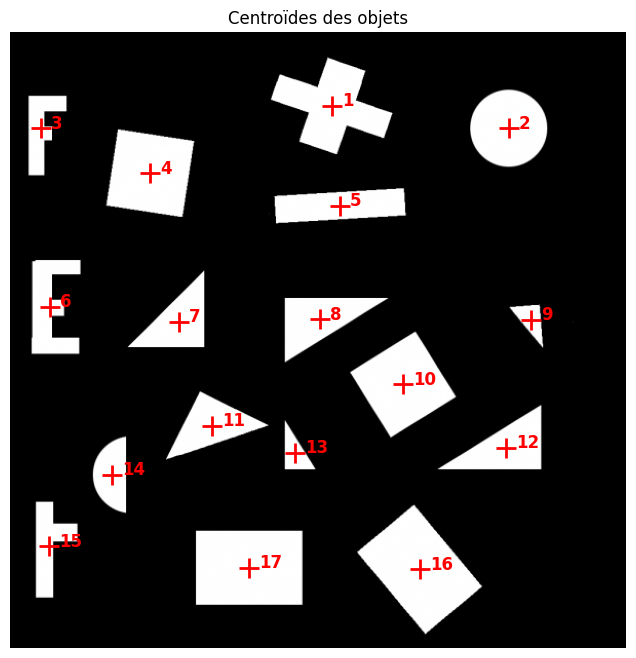

Objet 1: 8 coins détectés
Objet 2: 1 coins détectés
Objet 3: 4 coins détectés
Objet 4: 0 coins détectés
Objet 5: 0 coins détectés
Objet 6: 6 coins détectés
Objet 7: 0 coins détectés
Objet 8: 0 coins détectés
Objet 9: 0 coins détectés
Objet 10: 0 coins détectés
Objet 11: 3 coins détectés
Objet 12: 0 coins détectés
Objet 13: 0 coins détectés
Objet 14: 0 coins détectés
Objet 15: 2 coins détectés
Objet 16: 5 coins détectés
Objet 17: 0 coins détectés


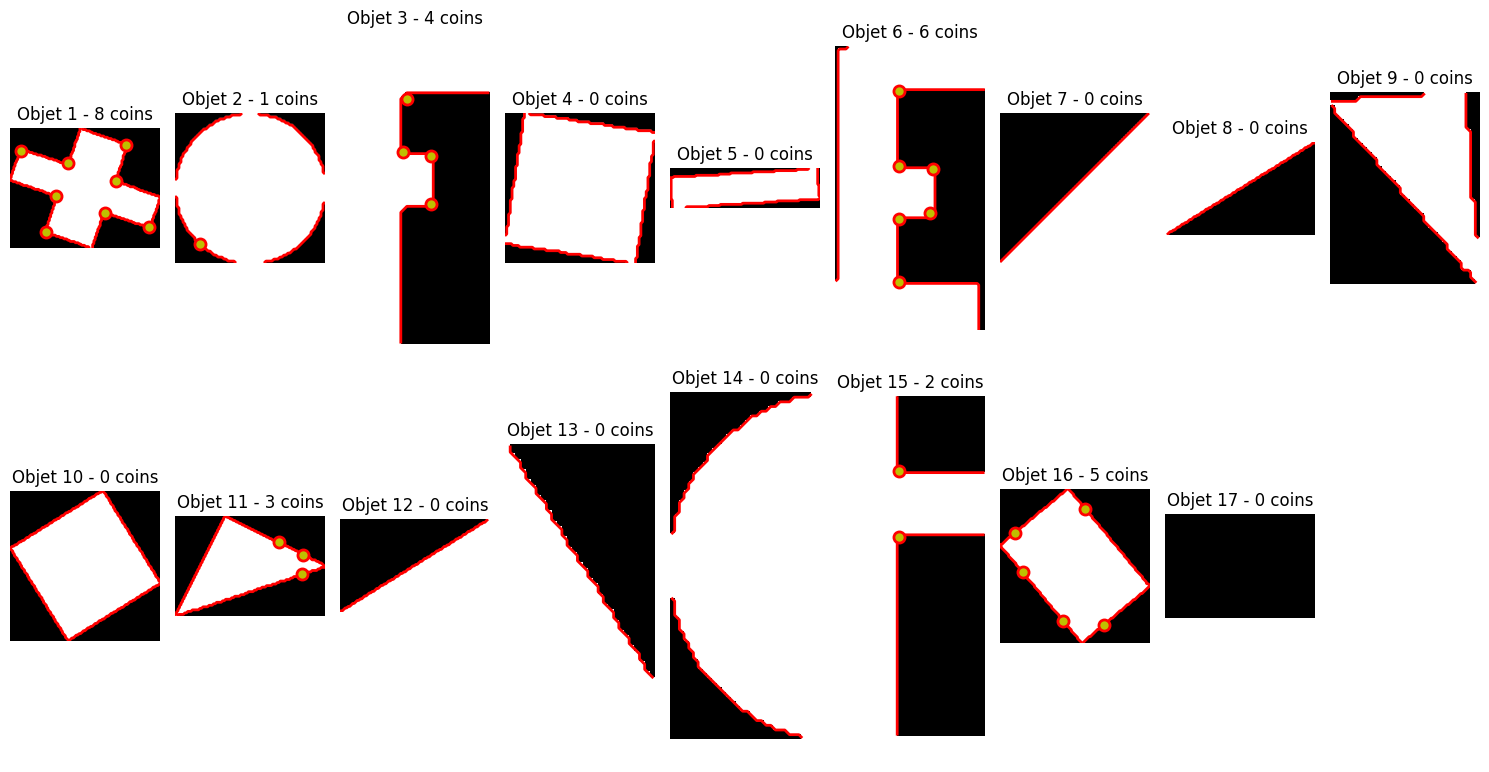

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops, find_contours
from skimage.feature import corner_harris, corner_peaks
from skimage.io import imread
from skimage.color import rgb2gray

# --- 1. Chargement et Pré-traitement  ---

imgShapes = imread('data/shapes.png')

# Convertir en grayscale si nécessaire
if imgShapes.ndim == 3:
    # VÉRIFICATION : L'image est-elle RGBA (4 canaux) ?
    if imgShapes.shape[2] == 4:
        print("Image détectée comme RGBA (4 canaux). Suppression du canal Alpha.")
        # Utiliser le slicing pour ne garder que les 3 premiers canaux (R, G, B)
        imgShapes_rgb = imgShapes[:, :, :3] 
    else:
        imgShapes_rgb = imgShapes

    # Conversion en niveaux de gris avec l'image 3 canaux
    imgShapes_gray = rgb2gray(imgShapes_rgb)
    
else:
    # C'est déjà une image 1D (niveaux de gris), donc pas de conversion nécessaire
    imgShapes_gray = imgShapes

# Maintenant, le reste du code peut continuer...
# Créer un masque binaire (seuillage)
threshold = 0.5
binary_shapes = imgShapes_gray > threshold 

# --- 2. Étiquetage (Connected Component Labeling) ---
# Cette étape identifie les groupes de pixels connectés comme des objets distincts


labeled_shapes = label(binary_shapes)
num_objects = labeled_shapes.max()
print(f"Nombre d'objets détectés: {num_objects}")

# Affichage de l'image originale et des labels
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(imgShapes, cmap='gray')
axes[0].set_title('Image originale')
axes[0].axis('off')

axes[1].imshow(labeled_shapes, cmap='nipy_spectral')
axes[1].set_title(f'Objets étiquetés ({num_objects} objets)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# --- 3. Propriétés des régions et Centroïdes ---

regions = regionprops(labeled_shapes)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(imgShapes, cmap='gray')
ax.set_title('Centroïdes des objets')

for region in regions:
    # Obtenir le centroïde
    cy, cx = region.centroid
    
    # Afficher quelques propriétés dans la console
    print(f"\nObjet {region.label}:")
    print(f"  Centroïde: ({cx:.1f}, {cy:.1f})")
    print(f"  Aire: {region.area}")
    print(f"  Périmètre: {region.perimeter:.1f}")
    print(f"  Excentricité: {region.eccentricity:.3f}")
    print(f"  Solidité: {region.solidity:.3f}")
    
    # Marquer le centroïde sur l'image
    ax.plot(cx, cy, 'r+', markersize=15, markeredgewidth=2)
    ax.text(cx + 10, cy, f'{region.label}', color='red', fontsize=12, fontweight='bold')

ax.axis('off')
plt.show()

# --- 4. Contours et Détection de coins (Harris Corner) ---
# Nous analysons chaque objet individuellement en extrayant sa "Bounding Box"

# Configuration de la grille de sous-graphiques
cols = int(np.ceil(num_objects/2))
rows = 2 if num_objects > 1 else 1
fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
if num_objects > 1:
    axes = axes.flatten()
else:
    axes = [axes]

for idx, region in enumerate(regions):
    # Extraire la région d'intérêt (ROI) grâce à la bounding box
    minr, minc, maxr, maxc = region.bbox
    roi = labeled_shapes[minr:maxr, minc:maxc]
    
    # Créer un masque binaire local pour cet objet spécifique
    roi_binary = (roi == region.label).astype(np.uint8)
    
    # Trouver les contours
    contours = find_contours(roi_binary, 0.5)
    
    # Détecter les coins avec Harris corner detector
    # Harris détecte les changements d'intensité forts dans deux directions
    
    corners = corner_harris(roi_binary.astype(float))
    corner_coords = corner_peaks(corners, min_distance=5, threshold_rel=0.1)
    num_corners = len(corner_coords)
    
    print(f"Objet {region.label}: {num_corners} coins détectés")
    
    # Affichage
    axes[idx].imshow(roi_binary, cmap='gray')
    axes[idx].set_title(f'Objet {region.label} - {num_corners} coins')
    axes[idx].axis('off')
    
    # Tracer les contours
    for contour in contours:
        axes[idx].plot(contour[:, 1], contour[:, 0], 'r-', linewidth=2)
    
    # Tracer les coins
    if len(corner_coords) > 0:
        axes[idx].plot(corner_coords[:, 1], corner_coords[:, 0], 'yo', 
                     markersize=8, markeredgecolor='red', markeredgewidth=2)

# Cacher les axes non utilisés s'il y en a
if num_objects > 1:
    for idx in range(num_objects, len(axes)):
        axes[idx].axis('off')

plt.tight_layout()
plt.show()

**Shape classifier**

We can now try to create a basic shape classifier. We can, for instance, try to differentiate between :

- Triangles
- Squares
- Rectangles
- Rounded shapes
- Complex shapes

By doing a very basic decision tree :

1. Count the number of corners n.
1. If n < 3 : rounded shape
1. If n == 3 : triangle
1. If n == 4 and eccentricity (given by regionprops) ~0 : square
1. If n == 4 and eccentricity >> 0 : rectangle
1. Else : complex shape


CLASSIFICATION DES FORMES

Objet 1:
  Nombre de coins (n): 8
  Excentricité: 0.638
  Classification: Complex shape

Objet 2:
  Nombre de coins (n): 1
  Excentricité: 0.052
  Classification: Rounded shape

Objet 3:
  Nombre de coins (n): 4
  Excentricité: 0.940
  Classification: Rectangle

Objet 4:
  Nombre de coins (n): 0
  Excentricité: 0.057
  Classification: Rounded shape

Objet 5:
  Nombre de coins (n): 0
  Excentricité: 0.978
  Classification: Rounded shape

Objet 6:
  Nombre de coins (n): 6
  Excentricité: 0.911
  Classification: Complex shape

Objet 7:
  Nombre de coins (n): 0
  Excentricité: 0.816
  Classification: Rounded shape

Objet 8:
  Nombre de coins (n): 0
  Excentricité: 0.879
  Classification: Rounded shape

Objet 9:
  Nombre de coins (n): 0
  Excentricité: 0.860
  Classification: Rounded shape

Objet 10:
  Nombre de coins (n): 0
  Excentricité: 0.028
  Classification: Rounded shape

Objet 11:
  Nombre de coins (n): 3
  Excentricité: 0.818
  Classification: Triangle



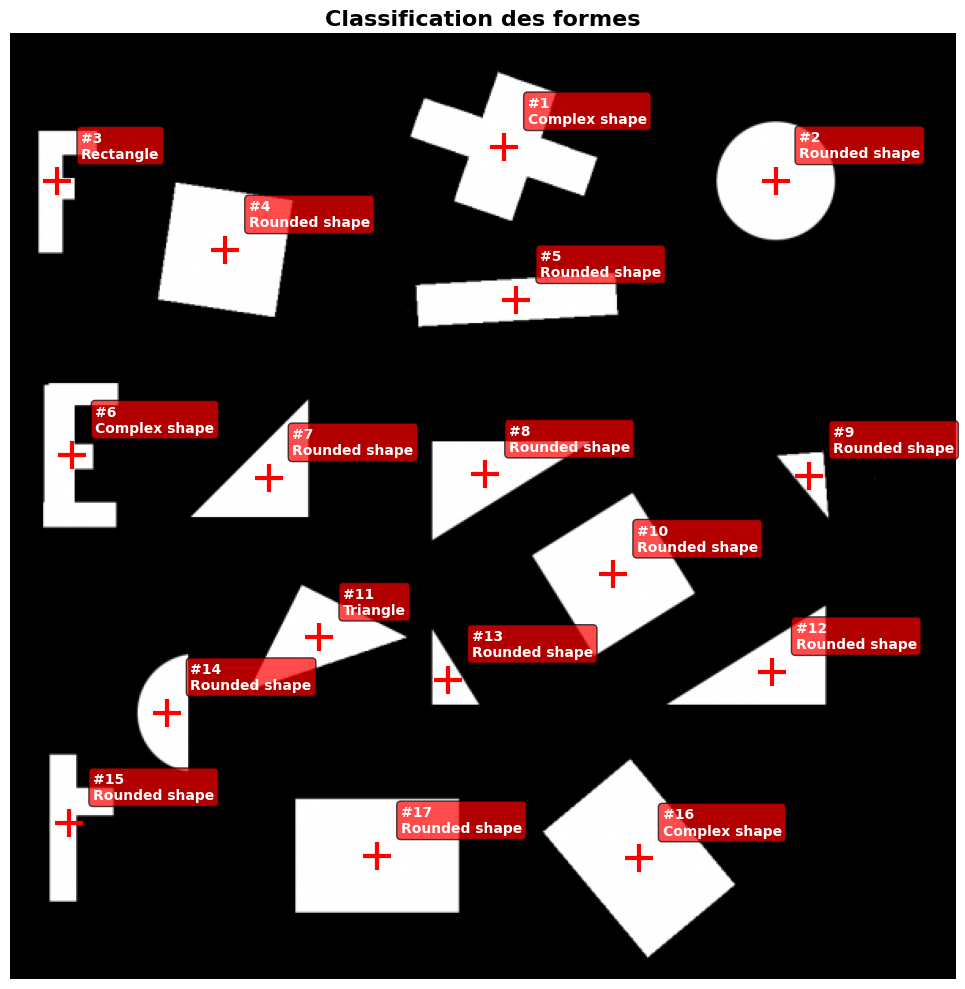


STATISTIQUES GLOBALES
Complex shape: 3
Rounded shape: 12
Rectangle: 1
Triangle: 1


In [31]:
# Shape classifier basé sur le nombre de coins et l'excentricité

def classify_shape(num_corners, eccentricity):
    """
    Classifie une forme selon le nombre de coins et l'excentricité
    
    Paramètres:
    - num_corners: nombre de coins détectés
    - eccentricity: excentricité de la région (0 = cercle, ~1 = ligne)
    
    Retourne:
    - str: catégorie de la forme
    """
    if num_corners < 3:
        return "Rounded shape"
    elif num_corners == 3:
        return "Triangle"
    elif num_corners == 4:
        # Distinguer carré et rectangle selon l'excentricité
        # Excentricité proche de 0 = carré, élevée = rectangle
        if eccentricity < 0.5:  # ~0 signifie proche de 0
            return "Square"
        else:  # >> 0 signifie beaucoup plus grand que 0
            return "Rectangle"
    else:
        return "Complex shape"

# Classifier tous les objets
print("\n" + "="*60)
print("CLASSIFICATION DES FORMES")
print("="*60)

classifications = []

for region in regions:
    # Extraire la région d'intérêt
    minr, minc, maxr, maxc = region.bbox
    roi = labeled_shapes[minr:maxr, minc:maxc]
    roi_binary = (roi == region.label).astype(np.uint8)
    
    # Détecter les coins avec Harris corner detector
    corners = corner_harris(roi_binary.astype(float))
    corner_coords = corner_peaks(corners, min_distance=5, threshold_rel=0.1)
    num_corners = len(corner_coords)
    
    # Classifier selon le decision tree
    shape_class = classify_shape(num_corners, region.eccentricity)
    classifications.append(shape_class)
    
    print(f"\nObjet {region.label}:")
    print(f"  Nombre de coins (n): {num_corners}")
    print(f"  Excentricité: {region.eccentricity:.3f}")
    print(f"  Classification: {shape_class}")

# Visualisation finale avec classifications
fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(imgShapes)
ax.set_title('Classification des formes', fontsize=16, fontweight='bold')

for idx, region in enumerate(regions):
    cy, cx = region.centroid
    
    # Afficher le label et la classification
    ax.plot(cx, cy, 'r+', markersize=20, markeredgewidth=3)
    ax.text(cx + 15, cy - 15, f"#{region.label}\n{classifications[idx]}", 
            color='white', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='red', alpha=0.7))

ax.axis('off')
plt.tight_layout()
plt.show()

# Statistiques globales
print("\n" + "="*60)
print("STATISTIQUES GLOBALES")
print("="*60)
from collections import Counter
class_counts = Counter(classifications)
for shape_type, count in class_counts.items():
    print(f"{shape_type}: {count}")

**Need more help? You can check the following videos:**

* [Object labeling & features](https://www.youtube.com/watch?v=7bOH4E7c8gU&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=33)

# Coding project - Tumour segmentation

The image below is a slice of a brain MRI with a large tumour in it. The goal of this project is to create an algorithm to automatically segment the tumour.

Given that the resolution of the image is of 0.115 cm/px in both axis, estimate the area of the tumour (in cm²). 

(218, 180, 3)


C:\Users\tajan\AppData\Local\Temp\ipykernel_12928\77023513.py:8: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(imgBrain)


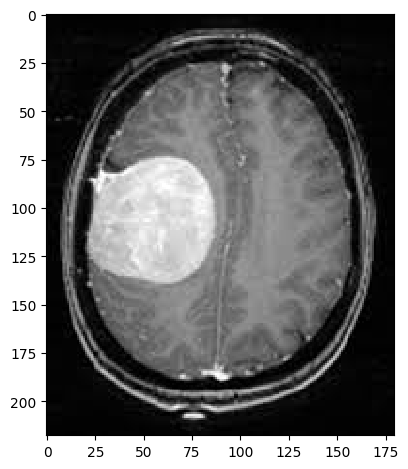

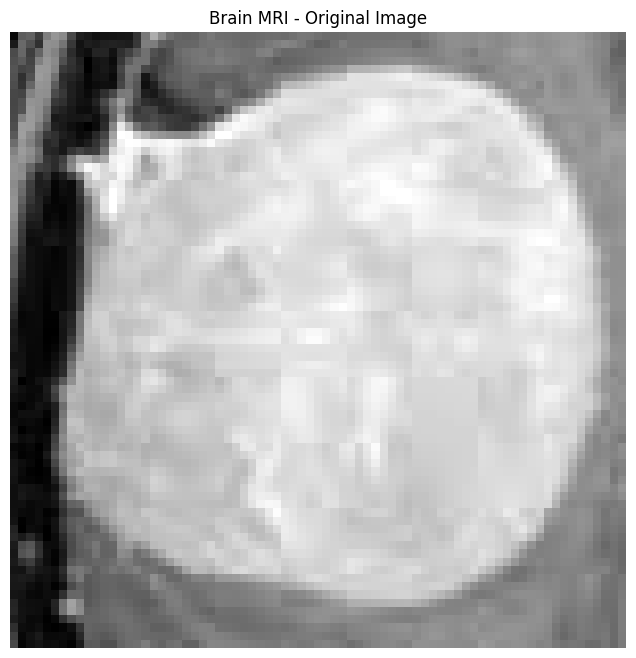

In [16]:
from skimage.io import imread, imshow
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

imgBrain = imread('data/mri_brain.jpg')
imshow(imgBrain)
print(imgBrain.shape)

#On crop pour moins se casser la tête

imgBrain = imgBrain[70:145, 15:90]

# Converbt to grayscale if needed
if imgBrain.ndim == 3:
    imgBrain = rgb2gray(imgBrain)

# Convert to proper range for display and processing
imgBrain = np.asarray(imgBrain, dtype=np.float64)

plt.figure(figsize=(8, 8))
plt.imshow(imgBrain, cmap='gray')
plt.title('Brain MRI - Original Image')
plt.axis('off')
plt.show()

In [ ]:
## -- Otsu's threshold-- ##
def otsu_threshold(h):
    """
    Trouve le seuil d'Otsu en maximisant la variance inter-classe
    h: histogramme normalisé (probabilités)
    """
    total = np.sum(h)
    h_norm = h / total  # normalisation
    
    bins = np.arange(256)
    mu_T = np.sum(bins * h_norm)  # moyenne globale
    
    best_t = 0
    max_sigma_b = 0
    
    for t in range(1, 256):
        # Poids des classes
        w0 = np.sum(h_norm[:t])
        w1 = np.sum(h_norm[t:])
        
        if w0 == 0 or w1 == 0:
            continue
        
        # Moyennes des classes
        mu0 = np.sum(bins[:t] * h_norm[:t]) / w0
        mu1 = np.sum(bins[t:] * h_norm[t:]) / w1
        
        # Variance inter-classe
        sigma_b = w0 * w1 * (mu0 - mu1) ** 2
        
        if sigma_b > max_sigma_b:
            max_sigma_b = sigma_b
            best_t = t
    
    return best_t

# Define optimal_threshold function
def optimal_threshold(h, t_init=128):
    """
    Trouve le seuil optimal en maximisant la distance entre les centroïdes
    h: histogramme (array de 256 valeurs)
    t_init: seuil initial
    """
    t = t_init
    for iteration in range(100):  # max 100 itérations
        # Calcul des centroïdes des 2 classes
        bins = np.arange(256)
        
        # Classe 1: pixels < t
        h1 = h[:t]
        w1 = np.sum(h1)
        if w1 > 0:
            mu1 = np.sum(bins[:t] * h1) / w1
        else:
            mu1 = 0
        
        # Classe 2: pixels >= t
        h2 = h[t:]
        w2 = np.sum(h2)
        if w2 > 0:
            mu2 = np.sum(bins[t:] * h2) / w2
        else:
            mu2 = 255
        
        # Nouveau seuil = moyenne des centroïdes
        t_new = int((mu1 + mu2) / 2)
        
        if t_new == t:
            break
        t = t_new
    
    return t

# Convert image to 0-255 range for histogram computation
imgBrain_uint8 = (imgBrain * 255).astype(np.uint8)
hist, bins = np.histogram(imgBrain_uint8.ravel(), bins=256, range=(0, 256))

print("otsu's threshold:", otsu_threshold(hist))

otsu's threshold: 156


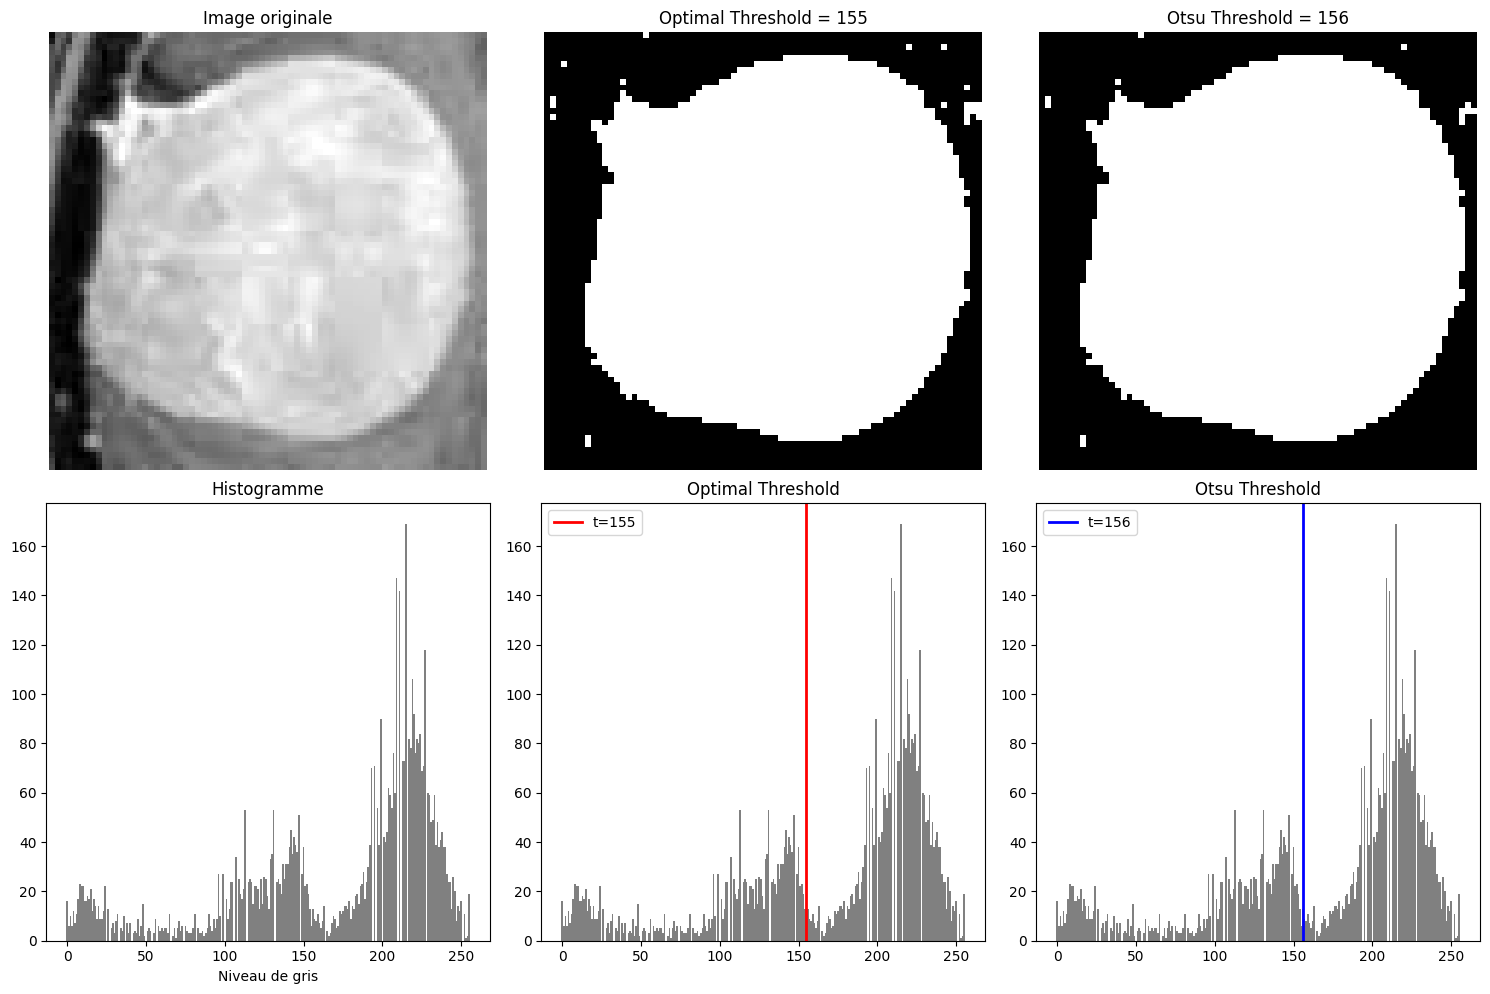

Seuil optimal: 155
Seuil d'Otsu: 156


In [ ]:
# Calculate thresholds
t_optimal = optimal_threshold(hist, t_init=128)
t_otsu = otsu_threshold(hist)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(imgBrain, cmap='gray')
axes[0, 0].set_title('Image originale')
axes[0, 0].axis('off')

imgOtsu = imgBrain_uint8 > t_optimal
axes[0, 1].imshow(imgBrain_uint8 > t_optimal, cmap='gray')
axes[0, 1].set_title(f'Optimal Threshold = {t_optimal}')
axes[0, 1].axis('off')

axes[0, 2].imshow(imgBrain_uint8 > t_otsu, cmap='gray')
axes[0, 2].set_title(f'Otsu Threshold = {t_otsu}')
axes[0, 2].axis('off')

# Histogrammes avec seuils
axes[1, 0].bar(bins[:-1], hist, width=1, color='gray')
axes[1, 0].set_title('Histogramme')
axes[1, 0].set_xlabel('Niveau de gris')

axes[1, 1].bar(bins[:-1], hist, width=1, color='gray')
axes[1, 1].axvline(t_optimal, color='red', linewidth=2, label=f't={t_optimal}')
axes[1, 1].set_title('Optimal Threshold')
axes[1, 1].legend()

axes[1, 2].bar(bins[:-1], hist, width=1, color='gray')
axes[1, 2].axvline(t_otsu, color='blue', linewidth=2, label=f't={t_otsu}')
axes[1, 2].set_title('Otsu Threshold')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

print(f"Seuil optimal: {t_optimal}")
print(f"Seuil d'Otsu: {t_otsu}")

3535
46.750375000000005


C:\Users\tajan\AppData\Local\Temp\ipykernel_12928\1842696003.py:6: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(imgOpened)


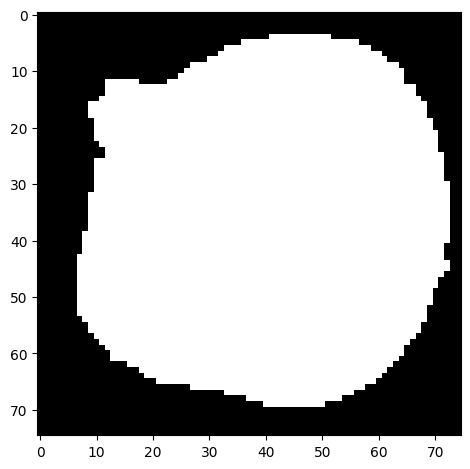

In [28]:
#Opening pour nettoyer l'output
from skimage.morphology import disk, opening

imgOpened = opening(imgOtsu, disk(1.6))

imshow(imgOpened)

count = np.sum(imgOpened)

print(count)

print(count * 0.115**2)